In [ ]:
%%capture
!pip install mediapipe

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/Data/AFLW2000-3D.zip

Archive:  /content/drive/MyDrive/Data/AFLW2000-3D.zip
   creating: AFLW2000/
   creating: AFLW2000/Code/
  inflating: AFLW2000/Code/DrawSolidHead.m  
  inflating: AFLW2000/Code/DrawTextureHead.m  
  inflating: AFLW2000/Code/main_show_without_BFM.m  
  inflating: AFLW2000/Code/main_show_with_BFM.m  
   creating: AFLW2000/Code/Mex/
  inflating: AFLW2000/Code/Mex/compile.m  
  inflating: AFLW2000/Code/Mex/Tnorm_Vnorm.h  
  inflating: AFLW2000/Code/Mex/Tnorm_VnormC.cpp  
  inflating: AFLW2000/Code/Mex/Tnorm_VnormC.mexw64  
   creating: AFLW2000/Code/ModelGeneration/
  inflating: AFLW2000/Code/ModelGeneration/ModelGenerate.m  
  inflating: AFLW2000/Code/ModelGeneration/model_info.mat  
  inflating: AFLW2000/Code/Model_Exp.mat  
  inflating: AFLW2000/Code/Model_Shape_Sim.mat  
  inflating: AFLW2000/Code/NormDirection.m  
  inflating: AFLW2000/Code/readme.txt  
  inflating: AFLW2000/Code/RotationMatrix.m  
  inflating: AFLW2000/Code/Tnorm_VnormC.mexw64  
  inflating: AFLW2000/image00002.jpg  

In [1]:
import numpy as np
import os,cv2,math,glob,random
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import pandas as pd
import mediapipe
import warnings
warnings.filterwarnings('ignore')
from google.colab.patches import cv2_imshow
from sklearn.model_selection import cross_val_score,GridSearchCV
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score,train_test_split


In [2]:
def get_file_names():
  file_names = []
  for file_name in sorted(os.listdir('/content/AFLW2000/')):
    if file_name.endswith(".jpg") :
      file_names.append(file_name)
  return file_names


In [3]:
# Read Pose Parameter from mat file
def read_mat_Pose(filename):
  return sio.loadmat(filename)['Pose_Para'][0][:3]

In [4]:
pose = []
All_Images=[]
for file_name in sorted(os.listdir('/content/AFLW2000/')):
  if file_name.endswith(".mat"):
    pose.append(read_mat_Pose('/content/AFLW2000/' + file_name))
    All_Images.append(file_name.replace('.mat', ''))


labels = pd.concat([pd.DataFrame(pose, columns= ['pitch','yaw','roll']),pd.DataFrame(All_Images, columns= ['image'])],axis =1)

In [5]:
labels.shape

(2000, 4)

In [6]:
# choosing random image
file_names =  get_file_names()
x_list = []
y_list= []
img = []
pose=[]

for file_name in file_names:
  faceModule = mediapipe.solutions.face_mesh
  with faceModule.FaceMesh(static_image_mode=True) as faces:

      # image loading
      image = cv2.imread('/content/AFLW2000/' + file_name )
      
      # processing the face to extract the landmark points (468 point) for each x,y,z
      results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
      if results.multi_face_landmarks != None: 
        img.append(file_name.replace('.jpg', ''))
        
        # looping over the faces in the image
        for face in results.multi_face_landmarks:
          x_points = []
          y_points = []
          for landmark in face.landmark:
              x = landmark.x
              y = landmark.y
                 
              # scale x,y
              shape = image.shape 
              relative_x = int(x * shape[1])
              relative_y = int(y * shape[0])
              x_points.append(relative_x)
              y_points.append(relative_y)
          x_list.append(x_points)
          y_list.append(y_points)

In [7]:
x_points = np.array(x_list)
y_points = np.array(y_list)

In [8]:
print(x_points.shape)
print(y_points.shape)

(1853, 468)
(1853, 468)


In [9]:
len(img)

1853

In [10]:
# centering the data arround the 99th point 
Center_X = x_points - x_points[:,99].reshape(-1,1)
Center_Y = y_points - y_points[:,99].reshape(-1,1)

# computing the distance
distance = np.linalg.norm(np.array((x_points[:,10],y_points[:,10])) - np.array((x_points[:,152],y_points[:,152])),axis = 0).reshape(-1,1)
Norm_X = Center_X / distance
Norm_Y = Center_Y / distance

print(Norm_X.shape)
print(Norm_Y.shape)

# concatinating the X and Y points to form the compelete features
features = np.hstack([Norm_X,Norm_Y])
print(features.shape)

(1853, 468)
(1853, 468)
(1853, 936)


In [11]:
# de tmam
features

array([[ 0.04173556,  0.05008267,  0.05008267, ..., -0.25458691,
        -0.30884313, -0.32553735],
       [ 0.        , -0.06748339,  0.01840456, ..., -0.25152901,
        -0.28833813, -0.30674269],
       [ 0.05881222,  0.06861426,  0.05881222, ..., -0.24505094,
        -0.29406112, -0.30386316],
       ...,
       [ 0.02904114,  0.06776265,  0.04840189, ..., -0.20812814,
        -0.19360758, -0.20812814],
       [ 0.0412358 ,  0.05773012,  0.04948296, ..., -0.25566195,
        -0.29689775, -0.30926849],
       [ 0.05651693,  0.05216948,  0.04782202, ..., -0.25215246,
        -0.28258466, -0.29997448]])

In [12]:
img_df = pd.DataFrame(img)

In [13]:
features_df = pd.DataFrame(features)

In [14]:
dataSet = pd.concat([img_df,features_df],axis =1)
dataSet.head()

,0,0,1,2,3,4,5,6,7,8,...,926,927,928,929,930,931,932,933,934,935
0,image00002,0.041736,0.050083,0.050083,0.029215,0.050083,0.058430,0.075124,-0.187810,0.083471,...,0.008347,-0.004174,0.000000,0.012521,0.016694,-0.283802,-0.271281,-0.254587,-0.308843,-0.325537
1,image00004,0.000000,-0.067483,0.018405,-0.012270,-0.067483,-0.036809,0.061349,0.061349,0.092023,...,-0.018405,-0.024539,0.012270,-0.012270,0.000000,-0.269934,-0.257664,-0.251529,-0.288338,-0.306743
2,image00006,0.058812,0.068614,0.058812,0.019604,0.068614,0.068614,0.049010,-0.254853,0.039208,...,-0.009802,-0.019604,-0.019604,0.000000,0.000000,-0.264655,-0.254853,-0.245051,-0.294061,-0.303863
3,image00008,0.078045,0.004878,0.048778,-0.053656,-0.014633,-0.024389,-0.034145,-0.234135,-0.068289,...,-0.024389,-0.043900,-0.058534,-0.014633,-0.014633,-0.346325,-0.326814,-0.307302,-0.443881,-0.468270
4,image00013,0.065819,0.030715,0.043879,-0.017552,0.021940,0.013164,-0.004388,-0.232559,-0.017552,...,-0.030715,-0.048267,-0.030715,-0.026327,-0.017552,-0.280826,-0.267662,-0.258886,-0.337869,-0.346645


In [15]:
for image in All_Images:
  if image not in img:
    labels.drop(labels.index[labels['image'] == image], inplace=True)

labels.shape

(1853, 4)

In [16]:
X = dataSet.iloc[: , 1:]
y = labels.iloc[: ,:-1]

In [17]:
X.shape

(1853, 936)

In [18]:
y

,pitch,yaw,roll
0,-0.399231,0.018227,0.085676
1,0.470065,1.189533,0.300959
2,-0.184650,0.881137,-0.236852
3,-0.175379,0.299208,-0.373374
5,-0.026812,0.011965,-0.220662
...,...,...,...
1991,-0.306358,-0.283822,0.038554
1992,-0.367547,-0.429723,0.122791
1994,-0.156035,0.567114,-0.108536
1995,-0.197102,-0.070430,0.105118


In [19]:
y = y.reset_index()

In [20]:
y= y.drop('index', axis=1)

In [21]:
result_df = pd.concat([X, y], axis=1)
display(result_df)

,0,1,2,3,4,5,6,7,8,9,...,929,930,931,932,933,934,935,pitch,yaw,roll
0,0.041736,0.050083,0.050083,0.029215,0.050083,0.058430,0.075124,-0.187810,0.083471,0.087645,...,0.012521,0.016694,-0.283802,-0.271281,-0.254587,-0.308843,-0.325537,-0.399231,0.018227,0.085676
1,0.000000,-0.067483,0.018405,-0.012270,-0.067483,-0.036809,0.061349,0.061349,0.092023,0.085888,...,-0.012270,0.000000,-0.269934,-0.257664,-0.251529,-0.288338,-0.306743,0.470065,1.189533,0.300959
2,0.058812,0.068614,0.058812,0.019604,0.068614,0.068614,0.049010,-0.254853,0.039208,0.039208,...,0.000000,0.000000,-0.264655,-0.254853,-0.245051,-0.294061,-0.303863,-0.184650,0.881137,-0.236852
3,0.078045,0.004878,0.048778,-0.053656,-0.014633,-0.024389,-0.034145,-0.234135,-0.068289,-0.087801,...,-0.014633,-0.014633,-0.346325,-0.326814,-0.307302,-0.443881,-0.468270,-0.175379,0.299208,-0.373374
4,0.065819,0.030715,0.043879,-0.017552,0.021940,0.013164,-0.004388,-0.232559,-0.017552,-0.026327,...,-0.026327,-0.017552,-0.280826,-0.267662,-0.258886,-0.337869,-0.346645,-0.026812,0.011965,-0.220662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1848,0.042347,0.079989,0.051757,0.037642,0.084694,0.079989,0.056463,-0.282313,0.051757,0.056463,...,-0.009410,-0.004705,-0.291724,-0.277608,-0.268197,-0.329365,-0.338776,-0.306358,-0.283822,0.038554
1849,0.043980,0.087959,0.057173,0.048377,0.092357,0.092357,0.070367,-0.241887,0.070367,0.074765,...,0.000000,0.000000,-0.294663,-0.277071,-0.268275,-0.321051,-0.338642,-0.367547,-0.429723,0.122791
1850,0.029041,0.067763,0.048402,0.067763,0.082283,0.091964,0.116165,-0.140365,0.140365,0.159726,...,0.004840,0.014521,-0.217809,-0.212968,-0.208128,-0.193608,-0.208128,-0.156035,0.567114,-0.108536
1851,0.041236,0.057730,0.049483,0.037112,0.061854,0.065977,0.082472,-0.214426,0.090719,0.094842,...,0.004124,0.008247,-0.280403,-0.268033,-0.255662,-0.296898,-0.309268,-0.197102,-0.070430,0.105118


In [22]:
result_df.to_csv('AFLW2000csv.csv', index=False)

In [23]:
X_train,  X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state = 42)

In [24]:
from sklearn.svm import SVR
svr_pitch = SVR(C=100, kernel='poly')
svr_pitch.fit(X_train, y_train['pitch'])
pred = svr_pitch.predict(X_test)
print('pitch')
print(svr_pitch.score(X_train, y_train['pitch']))
print(svr_pitch.score(X_test, y_test['pitch']))
print("Train Error: ",mean_absolute_error(svr_pitch.predict(X_train),y_train['pitch']))
print("Test Error: ",mean_absolute_error(svr_pitch.predict(X_test),y_test['pitch']))



pitch
0.20754459232409128
0.7632256167018525
Train Error:  0.0956082808029464
Test Error:  0.07935327475264667


In [25]:
from sklearn.svm import SVR
svr_yaw = SVR(C=100, kernel='poly')
svr_yaw.fit(X_train, y_train['yaw'])
pred = svr_yaw.predict(X_test)
print('yaw')
print(svr_yaw.score(X_train, y_train['yaw']))
print(svr_yaw.score(X_test, y_test['yaw']))
print("Train Error: ",mean_absolute_error(svr_yaw.predict(X_train),y_train['yaw']))
print("Test Error: ",mean_absolute_error(svr_yaw.predict(X_test),y_test['yaw']))



yaw
0.8761543446824864
0.9636073590224222
Train Error:  0.06865140410082518
Test Error:  0.061137968355695446


In [26]:
from sklearn.svm import SVR
svr_roll = SVR(C=100, kernel='poly')
svr_roll.fit(X_train, y_train['roll'])
pred = svr_roll.predict(X_test)
print('roll')
print(svr_roll.score(X_train, y_train['roll']))
print(svr_roll.score(X_test, y_test['roll']))
print("Train Error: ",mean_absolute_error(svr_roll.predict(X_train),y_train['roll']))
print("Test Error: ",mean_absolute_error(svr_roll.predict(X_test),y_test['roll']))



roll
0.3370112091078451
0.7307555086700779
Train Error:  0.08361610789292277
Test Error:  0.07070851875673542


In [28]:
import pickle
with open('svr_roll.pkl', 'wb') as f:
  pickle.dump(svr_roll , f)


In [29]:
# save the model to disk
with open('svr_yaw.pkl', 'wb') as f:
  pickle.dump(svr_yaw , f)

In [30]:
with open('svr_pitch.pkl', 'wb') as f:
  pickle.dump(svr_pitch , f)

In [31]:
with open('svr_yaw.pkl', 'rb') as f:
    yaw_model = pickle.load(f)

In [32]:
with open('svr_pitch.pkl', 'rb') as f:
    pitch_model = pickle.load(f)

In [33]:
with open('svr_roll.pkl', 'rb') as f:
    roll_model = pickle.load(f)

In [34]:
#pitch = pitch_model.predict(face_row)

In [35]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis (red)
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis (green)
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (blue)
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

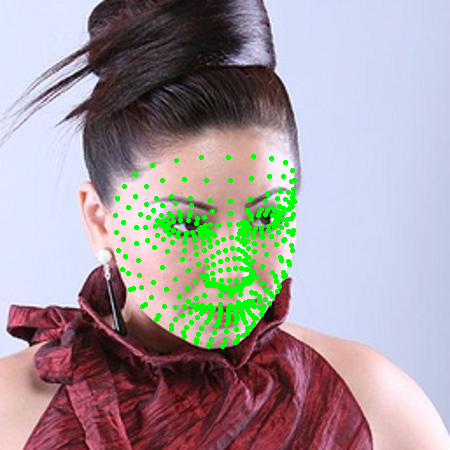

In [36]:
# choosing random image from the testing data
image_name = random.choice(labels['image'])
faceModule = mediapipe.solutions.face_mesh
with faceModule.FaceMesh(static_image_mode=True) as face:
  # reading the image
  frame = cv2.imread('/content/AFLW2000/' + image_name + '.jpg')
  # processing the image to detect the face and then generating the land marks (468 for each x,y,z).
  results = face.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
  if results.multi_face_landmarks != None:
    for face in results.multi_face_landmarks:
        # 
        for j,landmark in enumerate(face.landmark):
            x = landmark.x
            y = landmark.y
            shape = frame.shape 
            relative_x = int(x * shape[1])
            relative_y = int(y * shape[0])
            cv2.circle(frame, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
            #cv2.putText(frame, str(j), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,0,255), 2)
    cv2_imshow(frame)

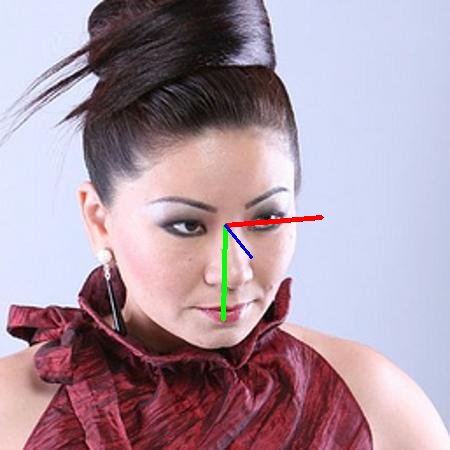

In [37]:
# reading the image
frame = cv2.imread('/content/AFLW2000/' + image_name + '.jpg')
# reading the true labels and drawing the axis on the image
mat = sio.loadmat('/content/AFLW2000/' + image_name + '.mat')
pitch_true = mat["Pose_Para"][0][0]
yaw_true = mat["Pose_Para"][0][1]
roll_true = mat["Pose_Para"][0][2]
cv2_imshow(draw_axis(frame,pitch_true,yaw_true,roll_true))

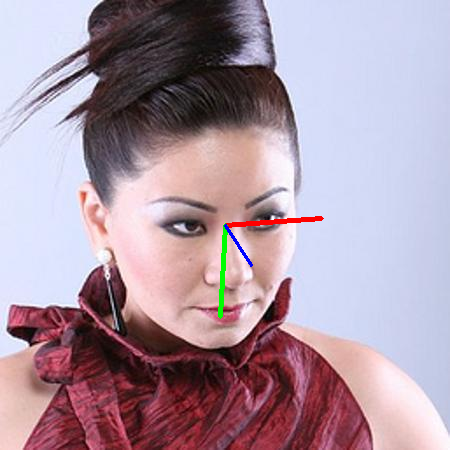

In [38]:
# choosing random image from the testing data
faceModule = mediapipe.solutions.face_mesh
with faceModule.FaceMesh(static_image_mode=True) as face:
  # reading the image
  frame = cv2.imread('/content/AFLW2000/' + image_name + '.jpg')
  # processing the image to detect the face and then generating the land marks (468 for each x,y,z).
  results = face.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
  if results.multi_face_landmarks != None:
    for face in results.multi_face_landmarks:
        # initializing two lists to store x and y points
        X = []
        Y = []
        for j,landmark in enumerate(face.landmark):
            x = landmark.x
            y = landmark.y
            # getting the points back to its actual values
            shape = frame.shape 
            relative_x = int(x * shape[1])
            relative_y = int(y * shape[0])
            # appending the points to the X and Y lists
            X.append(relative_x)
            Y.append(relative_y)

        # converting the x and y points to numpy array
        X = np.array(X)
        Y = np.array(Y)

        # centering the points of x and y values arround the point no. 99
        X_center = X - X[99]
        Y_center = Y - Y[99]
        # computing the distance between the point 152 and 10
        d = np.linalg.norm(np.array((X[152],Y[152])) - np.array((X[10],Y[10])))
        # normalizing the points
        X_norm = X_center/d
        Y_norm = Y_center/d
        X_norm = X_norm
        Y_norm = Y_norm
        # concatinating the x and y points to predict the labels (pitch,yaw,roll)
        points = np.hstack([X_norm,Y_norm]).reshape(1,-1)
        # predicting the 3 angels to draw the axis on the image

        yaw_pred =svr_yaw.predict(points)
        pitch_pred =svr_pitch.predict(points)
        roll_pred =svr_roll.predict(points)

        cv2_imshow(draw_axis(frame,pitch_pred,yaw_pred,roll_pred))